### Obter Contratos Publicos recentes de origem da Covilhã

In [12]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from urllib.parse import urlencode
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import time
import logging
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [4]:
def contratos_publicos(pais:'187', distrito:'6', concelho:'68', desdedatacontrato: '2024-03-01', atedatacontrato:'2024-03-31'):
    # Base URL
    base_url = 'https://www.base.gov.pt/Base4/pt/pesquisa/'

    # Query parameters
    payload = {
                'type':'contratos',
                'texto':'',
                'tipo':'0',
                'tipocontrato':'0',
                'cpv':'',
                'aqinfo':'',
                'adjudicante':'',
                'adjudicataria':'',
                'sel_price':'price_c1',
                'desdeprecocontrato':'',
                'ateprecocontrato':'',
                'desdeprecoefectivo':'',
                'ateprecoefectivo':'',
                'desdeprazoexecucao':'',
                'ateprazoexecucao':'',
                'sel_date':'date_c1',
                'desdedatacontrato':desdedatacontrato,
                'atedatacontrato':atedatacontrato,
                'desdedatapublicacao':'',
                'atedatapublicacao':'',
                'desdedatafecho':'',
                'atedatafecho':'',
                'pais': pais,
                'distrito': distrito,
                'concelho':concelho
    }

    # Encode parameters
    query_string = urlencode(payload)

    # Full URL
    url_covilha = f"{base_url}?{query_string}"
    
    
    ########################################
    # Extract content from website
    ########################################

    # Initialize WebDriver
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

    # Open URL
    driver.get(url_covilha)

    # Process info
    print("Start extracting content")

    # Wait
    time.sleep(30)

    # Locate the table
    table = driver.find_element(By.CLASS_NAME, 'table-striped')

    # Assuming headers are in the first row
    headers = [th.text for th in table.find_elements(By.TAG_NAME, "th")]
    print("Set headers")

    overall_dict = {}
    for index, row in enumerate(table.find_elements(By.TAG_NAME, "tr")[1:], start=1):
        cells = row.find_elements(By.TAG_NAME, "td")
        row_dict = {headers[i]: cell.text for i, cell in enumerate(cells)}
        overall_dict[f"row_{index}"] = row_dict

    print("Finish extraction")

    # Close the browser
    driver.quit()
    
    
    ########################################
    # Convert from dictionary to dataframe
    ########################################
    df_rows = pd.DataFrame.from_dict(overall_dict, orient='index')
    
    print("Returning dataframe")
    return df_rows


In [5]:
# Generate date range
date_range = pd.date_range(start='2023-01-01', end='2023-01-05', freq='D')

# Initialize an empty DataFrame
covilha = pd.DataFrame()

for date in date_range:
    params = {
        'pais': '187',
        'distrito': '6',
        'concelho': '68',
        'desdedatacontrato': date.strftime('%Y-%m-%d'),
        'atedatacontrato': date.strftime('%Y-%m-%d')  # Same day
    }
    try:
        df = contratos_publicos(**params)
        covilha = pd.concat([covilha, df], ignore_index=True)
    except Exception as e:
        print(f"Error for period starting {params['desdedatacontrato']}: {e}")
        continue


Start extracting content
Set headers
Finish extraction
Returning dataframe
Start extracting content
Set headers
Finish extraction
Returning dataframe
Start extracting content
Set headers
Finish extraction
Returning dataframe
Start extracting content
Set headers
Finish extraction
Returning dataframe
Start extracting content
Set headers
Finish extraction
Returning dataframe


In [6]:
covilha['Preço contratual'] = covilha['Preço contratual'].apply(lambda x: float(x.replace('€', '').replace('.', '').replace(',', '.')))


In [7]:
covilha.dtypes

Objeto do contrato       object
Tipo de procedimento     object
Adjudicante              object
Adjudicatário            object
Preço contratual        float64
Publicação               object
                         object
dtype: object

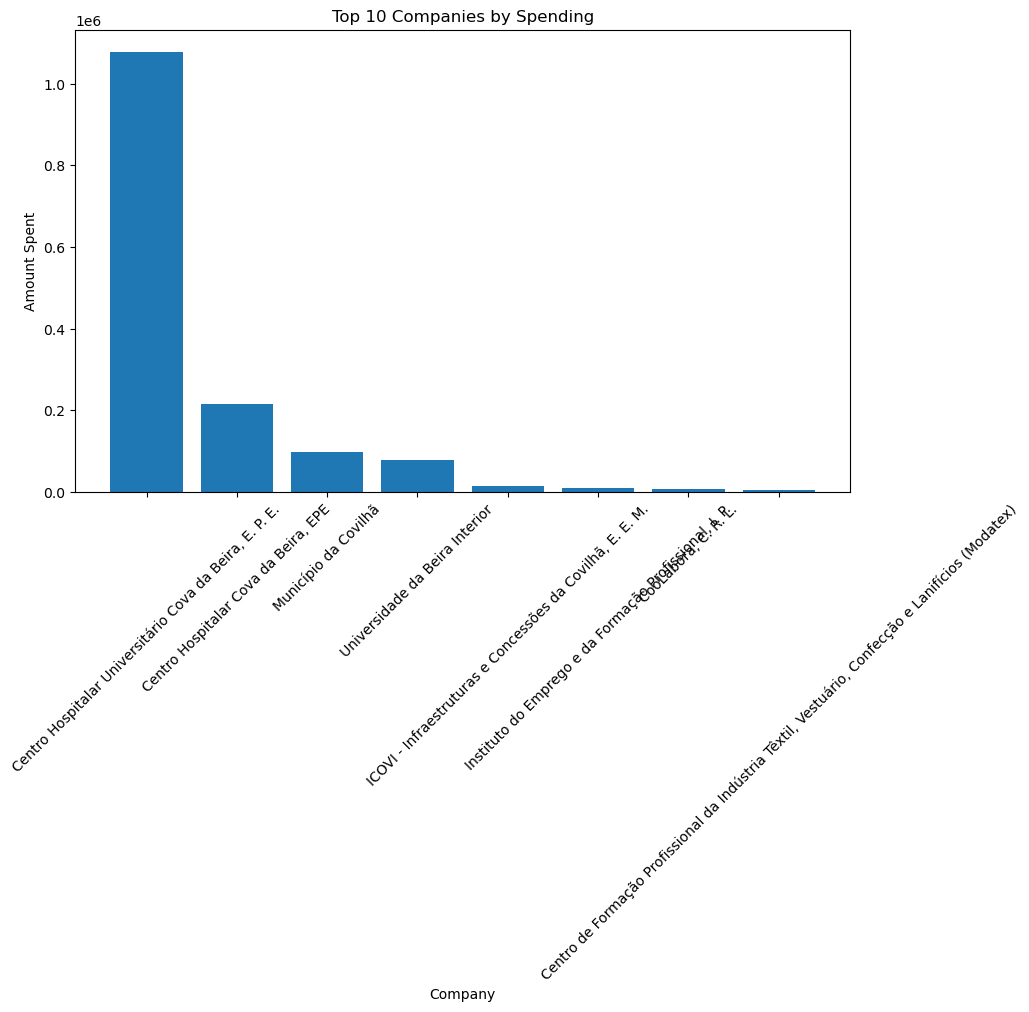

In [10]:
# Convert 'Preço contratual' to numerical format first, if not already done

# Sum and sort to find top companies by spending
total_spent = covilha.groupby('Adjudicante')['Preço contratual'].sum().reset_index()
top_companies = total_spent.sort_values('Preço contratual', ascending=False).head(10)  # Descending order for top spenders

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(top_companies['Adjudicante'], top_companies['Preço contratual'])
plt.xlabel('Company')
plt.ylabel('Amount Spent')
plt.title('Top 10 Companies by Spending')
plt.yscale('linear')
plt.xticks(rotation=45)
plt.show()


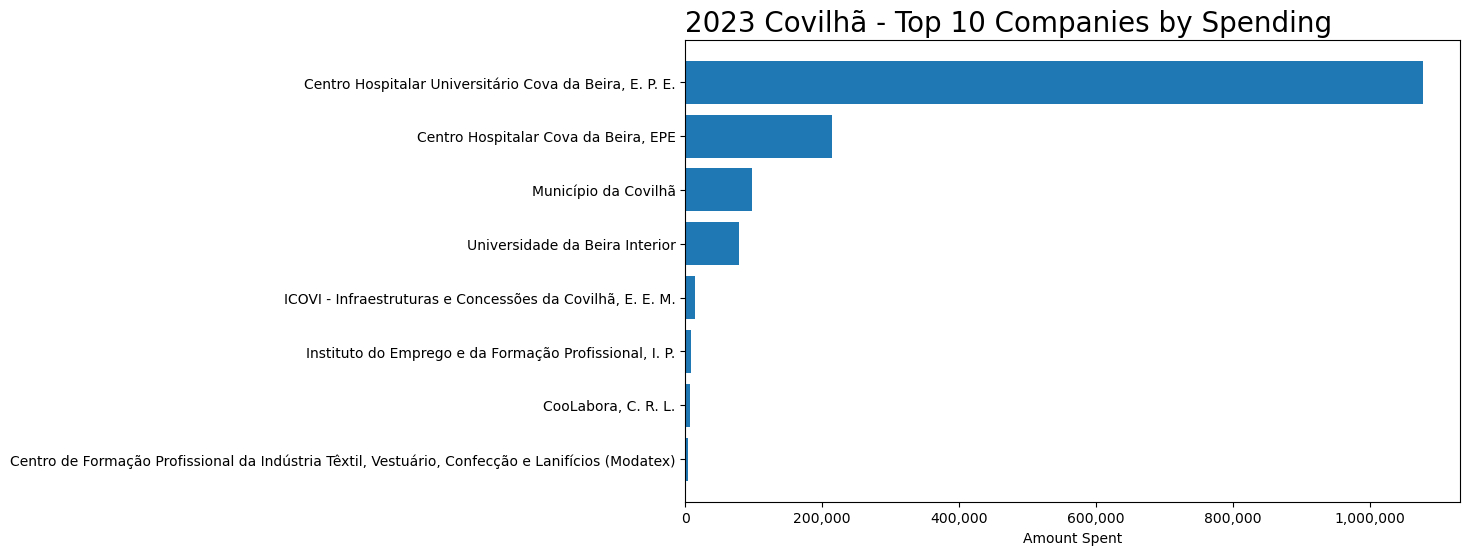

In [13]:
# Reverse the DataFrame to display bars in descending order
top_companies_reversed = top_companies.iloc[::-1]

plt.figure(figsize=(10, 6))
plt.barh(top_companies_reversed['Adjudicante'], top_companies_reversed['Preço contratual'])
plt.xlabel('Amount Spent')
plt.title('2023 Covilhã - Top 10 Companies by Spending', fontsize=20, loc='left')
plt.yticks(fontsize=10)  # Adjust the fontsize as needed for y-axis (company names)

# Format x-axis to plain format
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.show()


In [14]:
total_spent.head(10)

,Adjudicante,Preço contratual
0,"Centro Hospitalar Cova da Beira, EPE",214992.75
1,"Centro Hospitalar Universitário Cova da Beira,...",1078279.22
2,Centro de Formação Profissional da Indústria T...,3699.60
3,"CooLabora, C. R. L.",6540.00
4,ICOVI - Infraestruturas e Concessões da Covilh...,14476.74
5,Instituto do Emprego e da Formação Profissiona...,8400.00
6,Município da Covilhã,96864.00
7,Universidade da Beira Interior,79099.00


In [15]:
top_companies

,Adjudicante,Preço contratual
1,"Centro Hospitalar Universitário Cova da Beira,...",1078279.22
0,"Centro Hospitalar Cova da Beira, EPE",214992.75
6,Município da Covilhã,96864.00
7,Universidade da Beira Interior,79099.00
4,ICOVI - Infraestruturas e Concessões da Covilh...,14476.74
5,Instituto do Emprego e da Formação Profissiona...,8400.00
3,"CooLabora, C. R. L.",6540.00
2,Centro de Formação Profissional da Indústria T...,3699.60
